In [2]:
# --- Importing useful libraries ---
import numpy as np
from scipy import stats, special
import pandas as pd
import math as math

# --- Pretty plots ---
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from matplotlib.lines import Line2D


rc('axes', axisbelow = True)
rc('font', **{'family': 'serif', 'serif': ["Palatino"]})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Palatino'
plt.rcParams['mathtext.it'] = 'Palatino:italic'
plt.rcParams['mathtext.bf'] = 'Palatino:bold'
rc('text', usetex=True)

import seaborn as sns

cmap = ListedColormap(sns.color_palette("rocket", 256))

sns.set_palette("mako")
# --- Random seed ---
np.random.seed(5731)

In [153]:
filename = 'galdata.csv'
df = pd.read_csv(filename)
df

Unnamed: 0          RA        Dec  redshift   d_comoving
0                0  195.071285  -0.590771  0.465648  1840.028878
1                1  195.022992  -0.610999  0.565802  2175.683002
2                2  195.079741   0.348981  0.612211  2324.468084
3                3  195.170574   0.359864  0.502060  1964.423026
4                4  195.204289   0.347267  0.559173  2154.085038
...            ...         ...        ...       ...          ...
850359      850359  221.591765  63.863893  0.199543   846.005115
850360      850360  221.554537  63.825759  0.201655   854.490480
850361      850361  223.989695  63.093170  0.267434  1114.143578
850362      850362  224.145463  62.983435  0.153101   656.784571
850363      850363  224.686399  62.837926  0.208536   882.090788

[850364 rows x 5 columns]

In [22]:
# --- Define utility functions ------------------
# -- Get 3D galaxy map in cartesian coordinates -
def cartesian_positions(data):
    # Convert RA and Dec from degrees to radians
    ra_rad = np.deg2rad(data['RA'].values)
    dec_rad = np.deg2rad(data['Dec'].values)
    r = data['d_comoving'].values  
    
    # Calculate Cartesian coordinates
    x = r * np.cos(dec_rad) * np.cos(ra_rad)
    y = r * np.cos(dec_rad) * np.sin(ra_rad)
    z = r * np.sin(dec_rad)
    return x, y, z

# --- Count galaxies within spheres ---
def count_galaxies_in_spheres(x, y, z, centers, radius):
    counts = []
    radius_squared = radius ** 2
    for center in centers:
        dx = x - center[0]
        dy = y - center[1]
        dz = z - center[2]
        distances_squared = dx**2 + dy**2 + dz**2
        count = np.sum(distances_squared <= radius_squared)
        counts.append(count)
    return np.array(counts)
# --- Generates sphere centers and count the number of galaxies inside them ---
def generate_dataset(data, num_spheres, radius, uniform_sampling = False):
    x, y, z = cartesian_positions(data)
    
    # Define the survey volume bounds
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    # Generate random sphere centers
    if uniform_sampling == False:
        # Randomly select sphere centers from galaxy positions
        indices = np.random.choice(len(x), size=num_spheres, replace=False)
        sphere_centers = np.column_stack((x[indices], y[indices], z[indices]))
        
        # Add small random offsets to the sphere centers
        max_offset = radius * 1.0 # Ensure spheres stay within survey area, something between 0.5 and 1.0
        offsets = np.random.uniform(-max_offset, max_offset, size=(num_spheres, 3))
        sphere_centers += offsets
        
        # Ensure spheres are within survey bounds
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        z_min, z_max = z.min(), z.max()
        
        sphere_centers[:, 0] = np.clip(sphere_centers[:, 0], x_min + radius, x_max - radius)
        sphere_centers[:, 1] = np.clip(sphere_centers[:, 1], y_min + radius, y_max - radius)
        sphere_centers[:, 2] = np.clip(sphere_centers[:, 2], z_min + radius, z_max - radius)

    else:
        sphere_centers = np.column_stack((
        np.random.uniform(x_min + radius, x_max - radius, num_spheres),
        np.random.uniform(y_min + radius, y_max - radius, num_spheres),
        np.random.uniform(z_min + radius, z_max - radius, num_spheres)
        ))
    
    counts = count_galaxies_in_spheres(x, y, z, sphere_centers, radius)
    return sphere_centers, counts


## Statistical model

### Poisson Likelihood analysis #TD: WRITE IN MORE DETAIL
1. $\theta$, mean number density of galaxies
2. $\Theta=[0, \infty)$
3. $\{ x_i\}$: Counts of galaxies per sphere. $\{ V(R_i)\}$: Volume of each sampling sphere, with $R_i = R = 10.0$ Mpc.
4. $\mathcal{X}$, all possible tuples of non-negative integers, with size equal to the number of spheres
5. $X_i \mid V_i, \theta \stackrel{i n d}{\sim} \operatorname{Poisson}\left(\theta V_i\right)$, a description of how the data arise
6. $\theta \sim \operatorname{Gamma}(a, b)$ and we choose $a$ and $b$ to encode our assumptions about $\theta$.

Let the total number of galaxies be $N$. The posterior distribution is $\displaystyle\theta \mid \{ x_i\}, \{ V_i\} \sim \operatorname{Gamma}\left(a + \sum_i^{N} x_i , b+ N V(R) \right)$.

### Negative Binomial Likelihood analysis #TD: NOT BEING CURRENTLY USED
As the sample is overdispersed, we will employ a Negative Binomial distribution $X| a, \theta \sim \mathrm{NegBin}(a, \theta)$. Its probability and expected value are respectively
$$ p(x|a,\theta) = \frac{\Gamma(a+x)}{x! \Gamma(a)} \theta^a (1-\theta)^x,$$
$$ \langle X| a, \theta \rangle = a \left( \frac{1 - \theta}{\theta} \right). $$
With a fixed $a > 0$ and conjugate prior $\theta \sim \mathrm{Beta}(b,c)$, the posterior distribution is given by $\theta|\{ x_i\} \sim \mathrm{Beta}(na +b, n \bar{x} +c)$. Given a set of observations $\{ x_i \}$ with sample mean $\bar{x}$, the posterior mean, our estimator for $\theta$, will be given by
$$ \langle  \theta|\{ x_i \} \rangle = \frac{na +b}{n(a + \bar{x}) + b +c}.$$
TD: WHAT VALUES OF a WILL BE USED? 

We fix three different values for the parameter $a$, to study the sensitivity of the inference with respect to it, namely $a \in [0.1, 1.0, 10.0]$. Finally, the hyperparameters chosen for the prior are $(b,c) = (1.0,1.0)$ such that $\theta \sim \mathrm{Uniform}(0,1)$, reflecting our lack of information about the parameter other than that $\theta \in [0,1]$.


In [71]:
# ----- Poisson Likelihood analysis functions -----
def posterior_mean_ci_poisson(data, alpha_prior, beta_prior):
    counts = data['Counts'].values[0]
    radius = data['Radius'].values[0]
    volume =  (4/3) * np.pi * radius**3
    num_spheres = len(data['Counts'].values[0])
    
    total_counts = counts.sum()
    total_volume = volume * num_spheres
    
    alpha_posterior = alpha_prior + total_counts
    beta_posterior = beta_prior + total_volume
    
    theta_mean = alpha_posterior / beta_posterior
    theta_variance = alpha_posterior / beta_posterior**2
    
    credible_interval = stats.gamma.interval(0.95, a=alpha_posterior, scale=1/beta_posterior) # is this correct? I think CDF is the way
    return theta_mean, credible_interval, alpha_posterior, beta_posterior

def posterior_distro_poisson(theta, alpha_post, beta_post):
    return stats.gamma.pdf(theta, a=alpha_post, scale=1/beta_post)

# ---- Negative Binomial Likelihood analysis -----
# TD: Write functions for neg bin

# def posterior_mean_ci_negbin(label, alpha_prior, beta_prior):
#     counts = dataset[dataset['Redshift Range'] == label]['Counts'].values[0]
#     radius = dataset[dataset['Redshift Range'] == label]['Radius'].values[0]
#     volume =  (4/3) * np.pi * radius**3
#     num_spheres = len(dataset[dataset['Redshift Range'] == label]['Counts'].values[0])
    
#     total_counts = counts.sum()
#     total_volume = volume * num_spheres
    
#     alpha_posterior = alpha_prior + total_counts
#     beta_posterior = beta_prior + total_volume
    
#     theta_mean = alpha_posterior / beta_posterior
#     theta_variance = alpha_posterior / beta_posterior**2
    
#     credible_interval = stats.gamma.interval(0.95, a=alpha_posterior, scale=1/beta_posterior)
#     return theta_mean, credible_interval, alpha_posterior, beta_posterior

# def posterior_distro_negbin(theta, alpha_post, beta_post):
#     return stats.gamma.pdf(theta, a=alpha_posterior, scale=1/beta_posterior)




## Redshift slices analysis 

In [142]:
# --- Generate some Datasets to be analyzed ---
# Sphere parameters
num_spheres = 1000  
radius = 10 # Sphere radius in Mpc
volume = (4/3) * np.pi * radius**3  # Sphere volume

# ---- Define Redshift Masks ----
lowz_min, lowz_max = 0.04, 0.12
midz_min, midz_max = 0.12, 0.20
hiz_min, hiz_max = 0.6, 0.68

z_min_list = [0.00,lowz_min, midz_min, hiz_min]
z_max_list = [1.00,lowz_max, midz_max, hiz_max]

def redshift_filter(data, z_min, z_max):
    z_mask = (data['redshift'] >= z_min) & (data['redshift'] <= z_max)
    return data[z_mask]

# Apply the mask to filter the data, generate dataset
redshift_ranges = {
    "All": df,
    "Low-Z": redshift_filter(df, lowz_min, lowz_max),
    "Mid-Z": redshift_filter(df, midz_min, midz_max),
    "High-Z": redshift_filter(df, hiz_min, hiz_max)
}

# Create a dictionary to store centers and counts for each redshift range
dataset_dict = {}

# Loop through the datasets and calculate the sample statistics
for label, subset in redshift_ranges.items():
    centers, counts = generate_dataset(subset, num_spheres, radius)
    dataset_dict[label] = {"centers": centers, "counts": counts}
    print(f"Dataset: {label} ")
    print(f"Number of {label} galaxies: ", len(subset))
    print(f"{label} Samples Mean = ", counts.mean())
    print(f"{label} Samples Var = ", counts.var())
    print(f"{label} Sample Mean/Sample Var = ", counts.mean() / counts.var())
    print(f"Estimate of a = ", counts.mean()**2 / (counts.var() - counts.mean()))
    print('--------------------------------------------------------------')

# Store the results in a pandas DataFrame for later use
dataset = pd.DataFrame({
    "Redshift Range": dataset_dict.keys(),
    "Centers": [dataset_dict[label]["centers"] for label in dataset_dict],
    "Counts": [dataset_dict[label]["counts"] for label in dataset_dict],
    "Radius": [radius for label in dataset_dict]
})

dataset

Dataset: All 
Number of All galaxies:  850364
All Samples Mean =  1.764
All Samples Var =  3.966304
All Sample Mean/Sample Var =  0.44474654489418863
Estimate of a =  1.4129275522362037
--------------------------------------------------------------
Dataset: Low-Z 
Number of Low-Z galaxies:  30636
Low-Z Samples Mean =  4.456
Low-Z Samples Var =  24.114064
Low-Z Sample Mean/Sample Var =  0.184788428860436
Estimate of a =  1.0100656911077308
--------------------------------------------------------------
Dataset: Mid-Z 
Number of Mid-Z galaxies:  47548
Mid-Z Samples Mean =  2.514
Mid-Z Samples Var =  6.929804
Mid-Z Sample Mean/Sample Var =  0.3627808232382907
Estimate of a =  1.4312673297999638
--------------------------------------------------------------
Dataset: High-Z 
Number of High-Z galaxies:  98323
High-Z Samples Mean =  1.058
High-Z Samples Var =  1.2686359999999999
High-Z Sample Mean/Sample Var =  0.8339665593598165
Estimate of a =  5.3142102964355615
----------------------------

Redshift Range                                            Centers  \
0            All  [[-1844.2544887956924, 523.4378415037378, 296....   
1          Low-Z  [[-224.14603127815565, 3.2539696086047147, 406...   
2          Mid-Z  [[-447.3777640909553, 75.75123851362052, 425.6...   
3         High-Z  [[-2179.9569167540403, -683.7011019882106, 616...   

                                              Counts  Radius  
0  [0, 3, 2, 1, 2, 0, 2, 4, 0, 1, 6, 9, 1, 5, 1, ...      10  
1  [10, 1, 0, 0, 2, 5, 3, 6, 1, 3, 1, 15, 3, 3, 2...      10  
2  [2, 2, 2, 2, 6, 5, 1, 2, 1, 1, 1, 1, 3, 1, 0, ...      10  
3  [1, 2, 0, 1, 1, 0, 0, 0, 3, 1, 0, 1, 2, 1, 1, ...      10

### Visualize redshift slices 

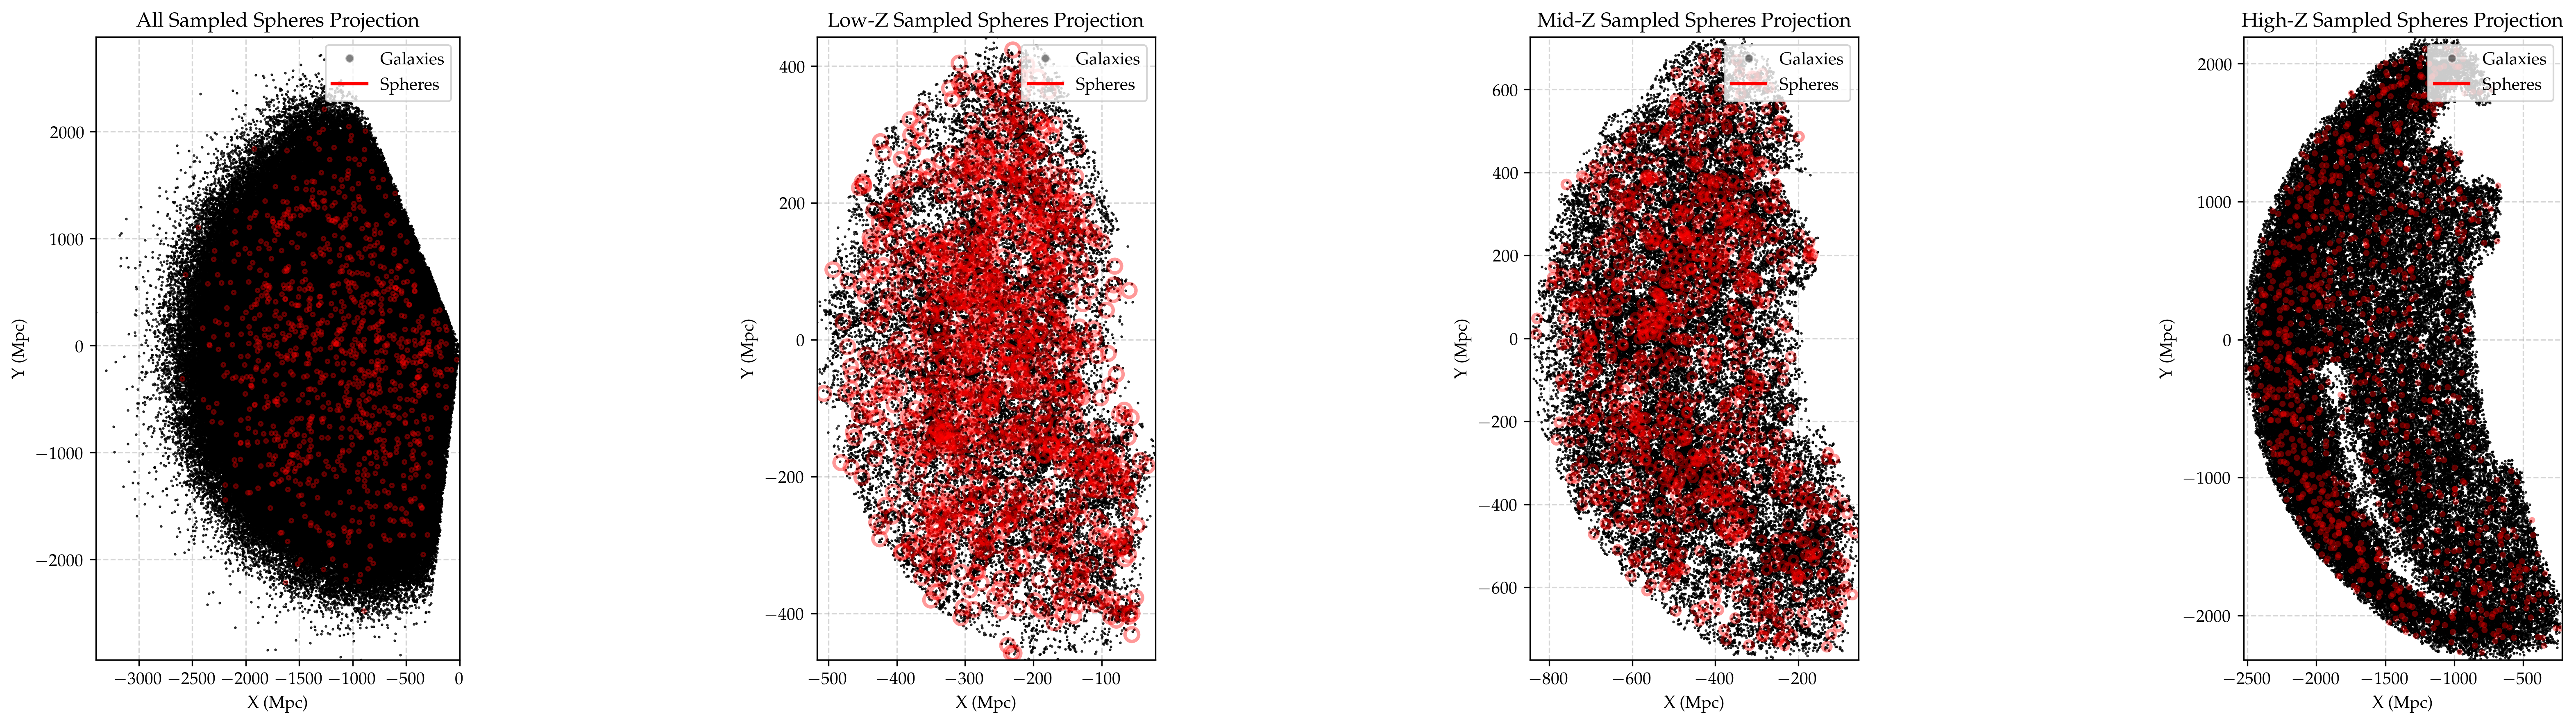

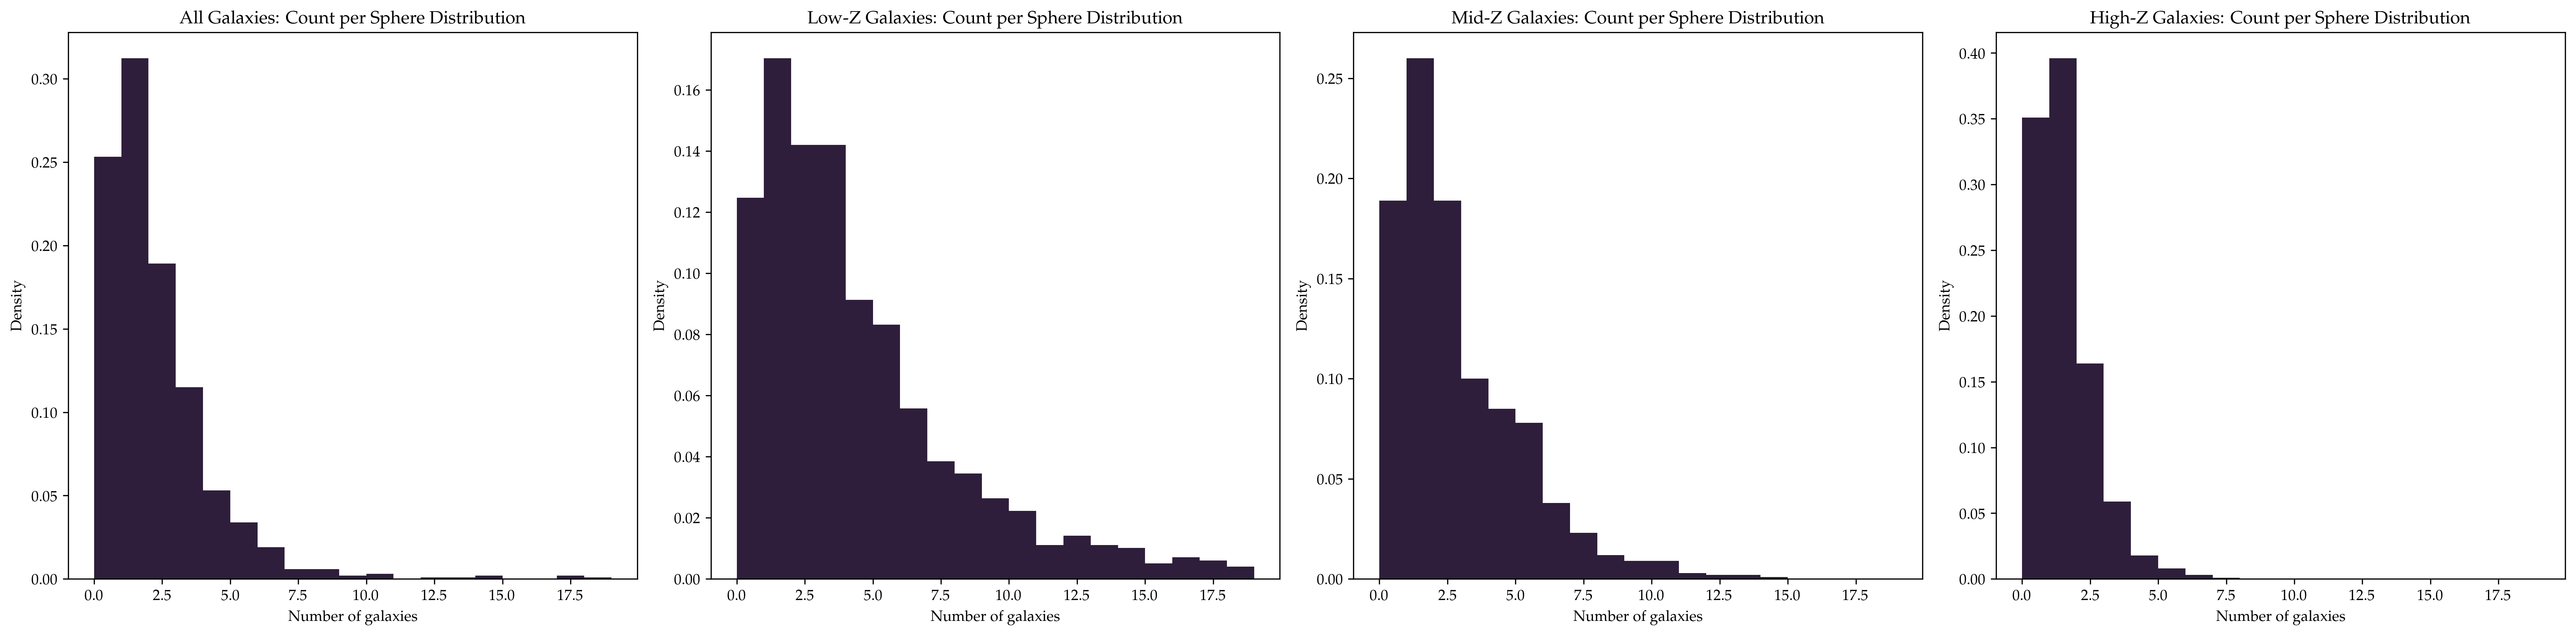

In [52]:
# TD: MAKE PLOTS PRETTIER :) 
fig, axs = plt.subplots(1, 4, figsize=(24, 6), dpi=300)

for i, label in enumerate(redshift_ranges.keys()):
    x, y, z = cartesian_positions(redshift_ranges[label])
    sphere_centers = dataset[dataset['Redshift Range'] == label]['Centers'].values[0]

    axs[i].scatter(x, y, s=1, marker = '.', c='black', alpha=0.9, label='Galaxies')

    for center in sphere_centers:
        circle = Circle((center[0], center[1]), radius, color='red', fill=False, linewidth=2, alpha=0.4)
        axs[i].add_patch(circle)

    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(y.min(), y.max())
    axs[i].set_xlabel('X (Mpc)')
    axs[i].set_ylabel('Y (Mpc)')
    axs[i].set_title(f'{label} Sampled Spheres Projection')

    axs[i].legend(handles=[
        Line2D([0], [0], marker='o', color='w', label='Galaxies', markerfacecolor='black', markersize=5, alpha=0.5),
        Line2D([0], [0], color='red', lw=2, label='Spheres')
    ], loc='upper right')
    axs[i].grid(True, linestyle='--', alpha=0.5)
    axs[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 4, figsize=(24, 6), dpi=300)

for i, label in enumerate(redshift_ranges.keys()):
    
    axs[i].hist( dataset[dataset['Redshift Range'] == label]['Counts'].values[0], bins=np.arange(0, 20, 1), density = True    )


    # axs[i].set_xlim(x.min(), x.max())
    # axs[i].set_ylim(y.min(), y.max())
    axs[i].set_xlabel('Number of galaxies')
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'{label} Galaxies: Count per Sphere Distribution')

    # axs[i].legend(handles=[
    #     Line2D([0], [0], marker='o', color='w', label='Galaxies', markerfacecolor='black', markersize=5, alpha=0.5),
    #     Line2D([0], [0], color='red', lw=2, label='Spheres')
    # ], loc='upper right')
    # axs[i].grid(True, linestyle='--', alpha=0.5)
    # axs[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


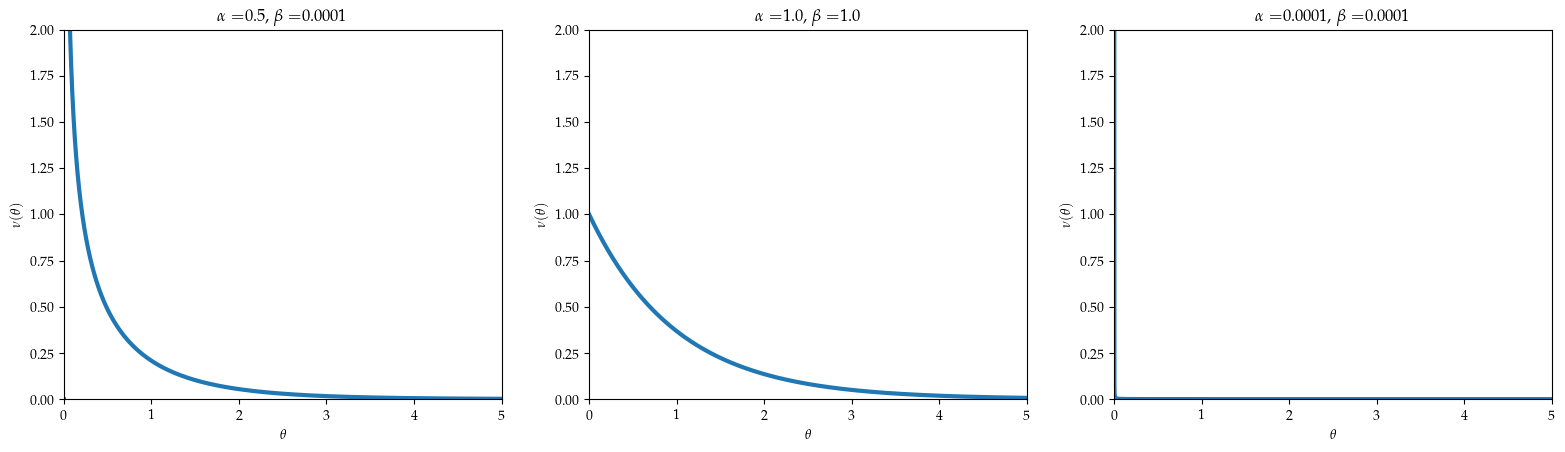

In [21]:
# Plot our three choices of priors next to one another
alpha = np.array([0.5, 1, 1e-4]);
beta = np.array([1e-4, 1, 1e-4]);

# Create axes
fig, axs = plt.subplots(ncols=len(alpha));
fig.set_figwidth(len(alpha)*fig.get_figwidth());

# x axis goes from 0 to 5
theta = np.arange(0, 5, 1e-5)

# Loop over priors
for i in range(len(alpha)):
    if alpha[i] == 1.0 and beta[i] == 1.0:
        nu = np.exp(-theta);
    else:
        nu = stats.gamma.pdf(theta, alpha[i], beta[i]);
    
    axs[i].plot(theta, nu, color='#1f77b4', linewidth=3);
    axs[i].set_title(fr'$\alpha=${alpha[i]}, $\beta=${beta[i]}');
    axs[i].set_xlabel(r'$\theta$');
    axs[i].set_ylabel(r'$\nu(\theta)$');
    axs[i].set_xlim(left=0, right=5);
    axs[i].set_ylim(bottom=0, top=2);

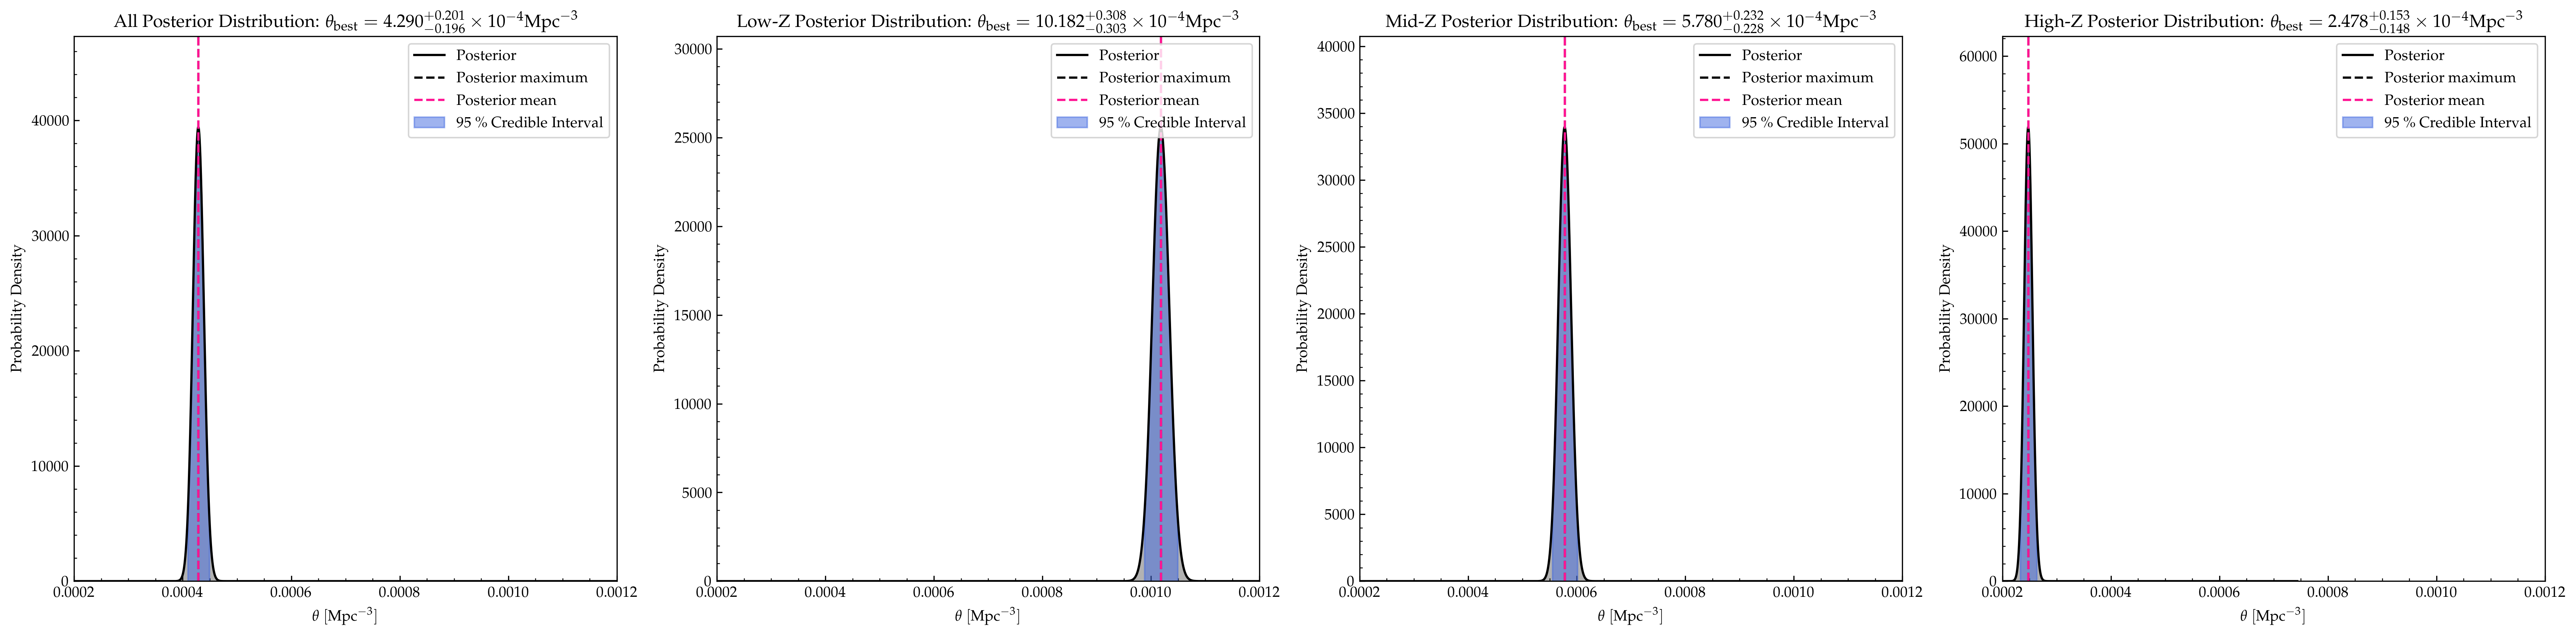

In [103]:
# Define labels for the datasets
labels = ["All", "Low-Z", "Mid-Z", "High-Z"]

# Define priors
alpha_prior = 1e-6  # Non-informative prior
beta_prior = 1e-6


fig, axs = plt.subplots(1, 4, figsize=(24, 6), dpi=300)

for i, label in enumerate(labels):
    
    data_subset = dataset[dataset['Redshift Range'] == label]
    
    theta_mean, credible_interval, alpha_posterior, beta_posterior = posterior_mean_ci_poisson(data_subset, alpha_prior, beta_prior)

    theta_values = np.linspace(0, theta_mean * 3, 5000)
    
    posterior_pdf = posterior_distro_poisson(theta_values, alpha_posterior, beta_posterior)
    prior_pdf = posterior_distro_poisson(theta_values, alpha_prior, beta_prior)

    posterior_maximum = theta_values[posterior_pdf.argmax()]
    mean, cfi_lower, cfi_upper = theta_mean, credible_interval[0], credible_interval[1]
    theta_fill = np.linspace(cfi_lower, cfi_upper, 1000)

    axs[i].plot(theta_values, posterior_pdf, color='black', label=r'Posterior')
    axs[i].axvline(posterior_maximum, linestyle='dashed', color='black', label=r'Posterior maximum')
    axs[i].axvline(mean, linestyle='dashed', color='deeppink', label=r'Posterior mean')
    axs[i].fill_between(theta_values, posterior_pdf, alpha=0.3, color='black')
    axs[i].fill_between(theta_fill, posterior_distro_poisson(theta_fill, alpha_posterior, beta_posterior),
                        alpha=0.5, color='royalblue', label=r'95 \% Credible Interval')
    
    # Plot the prior distribution
    #axs[i].plot(theta_values, prior_pdf, label='Prior', color='black', alpha=0.3)

    # Set plot labels, title, and limits
    axs[i].set_xlabel(r'$\theta$ $[\mathrm{Mpc}^{-3}]$')
    axs[i].set_ylabel(r'Probability Density')
    axs[i].set_title(f'{label} Posterior Distribution:' + r' $\theta_{\mathrm{best}}=' + f'{1e4*mean:.3f}' + r'^{+' + f'{1e4*(cfi_upper - mean):.3f}' + r'}_{-' + f'{1e4*(mean - cfi_lower):.3f}' + r'} \times 10^{-4} \mathrm{Mpc}^{-3}$')


    axs[i].tick_params(axis='both', which='major', direction='in')
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='minor', direction='in')
    axs[i].legend(loc='upper right')
    #axs[i].set_xlim(0.0, theta_mean * 3)
    axs[i].set_xlim(0.0002, 0.0012)
    axs[i].set_ylim(0, posterior_pdf.max() * 1.2)
    # axs[i].text(posterior_maximum * 1.2,  posterior_pdf.max() * 0.5, 
    #             r'$\theta_{\mathrm{best}}=' + f'{mean:.3f}' + r'^{+' + f'{cfi_upper - mean:.3f}' + r'}_{-' + f'{mean - cfi_lower:.3f}' + r'}$',
    #             fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipykernel_111143/3383141754.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('coolwarm', len(labels))


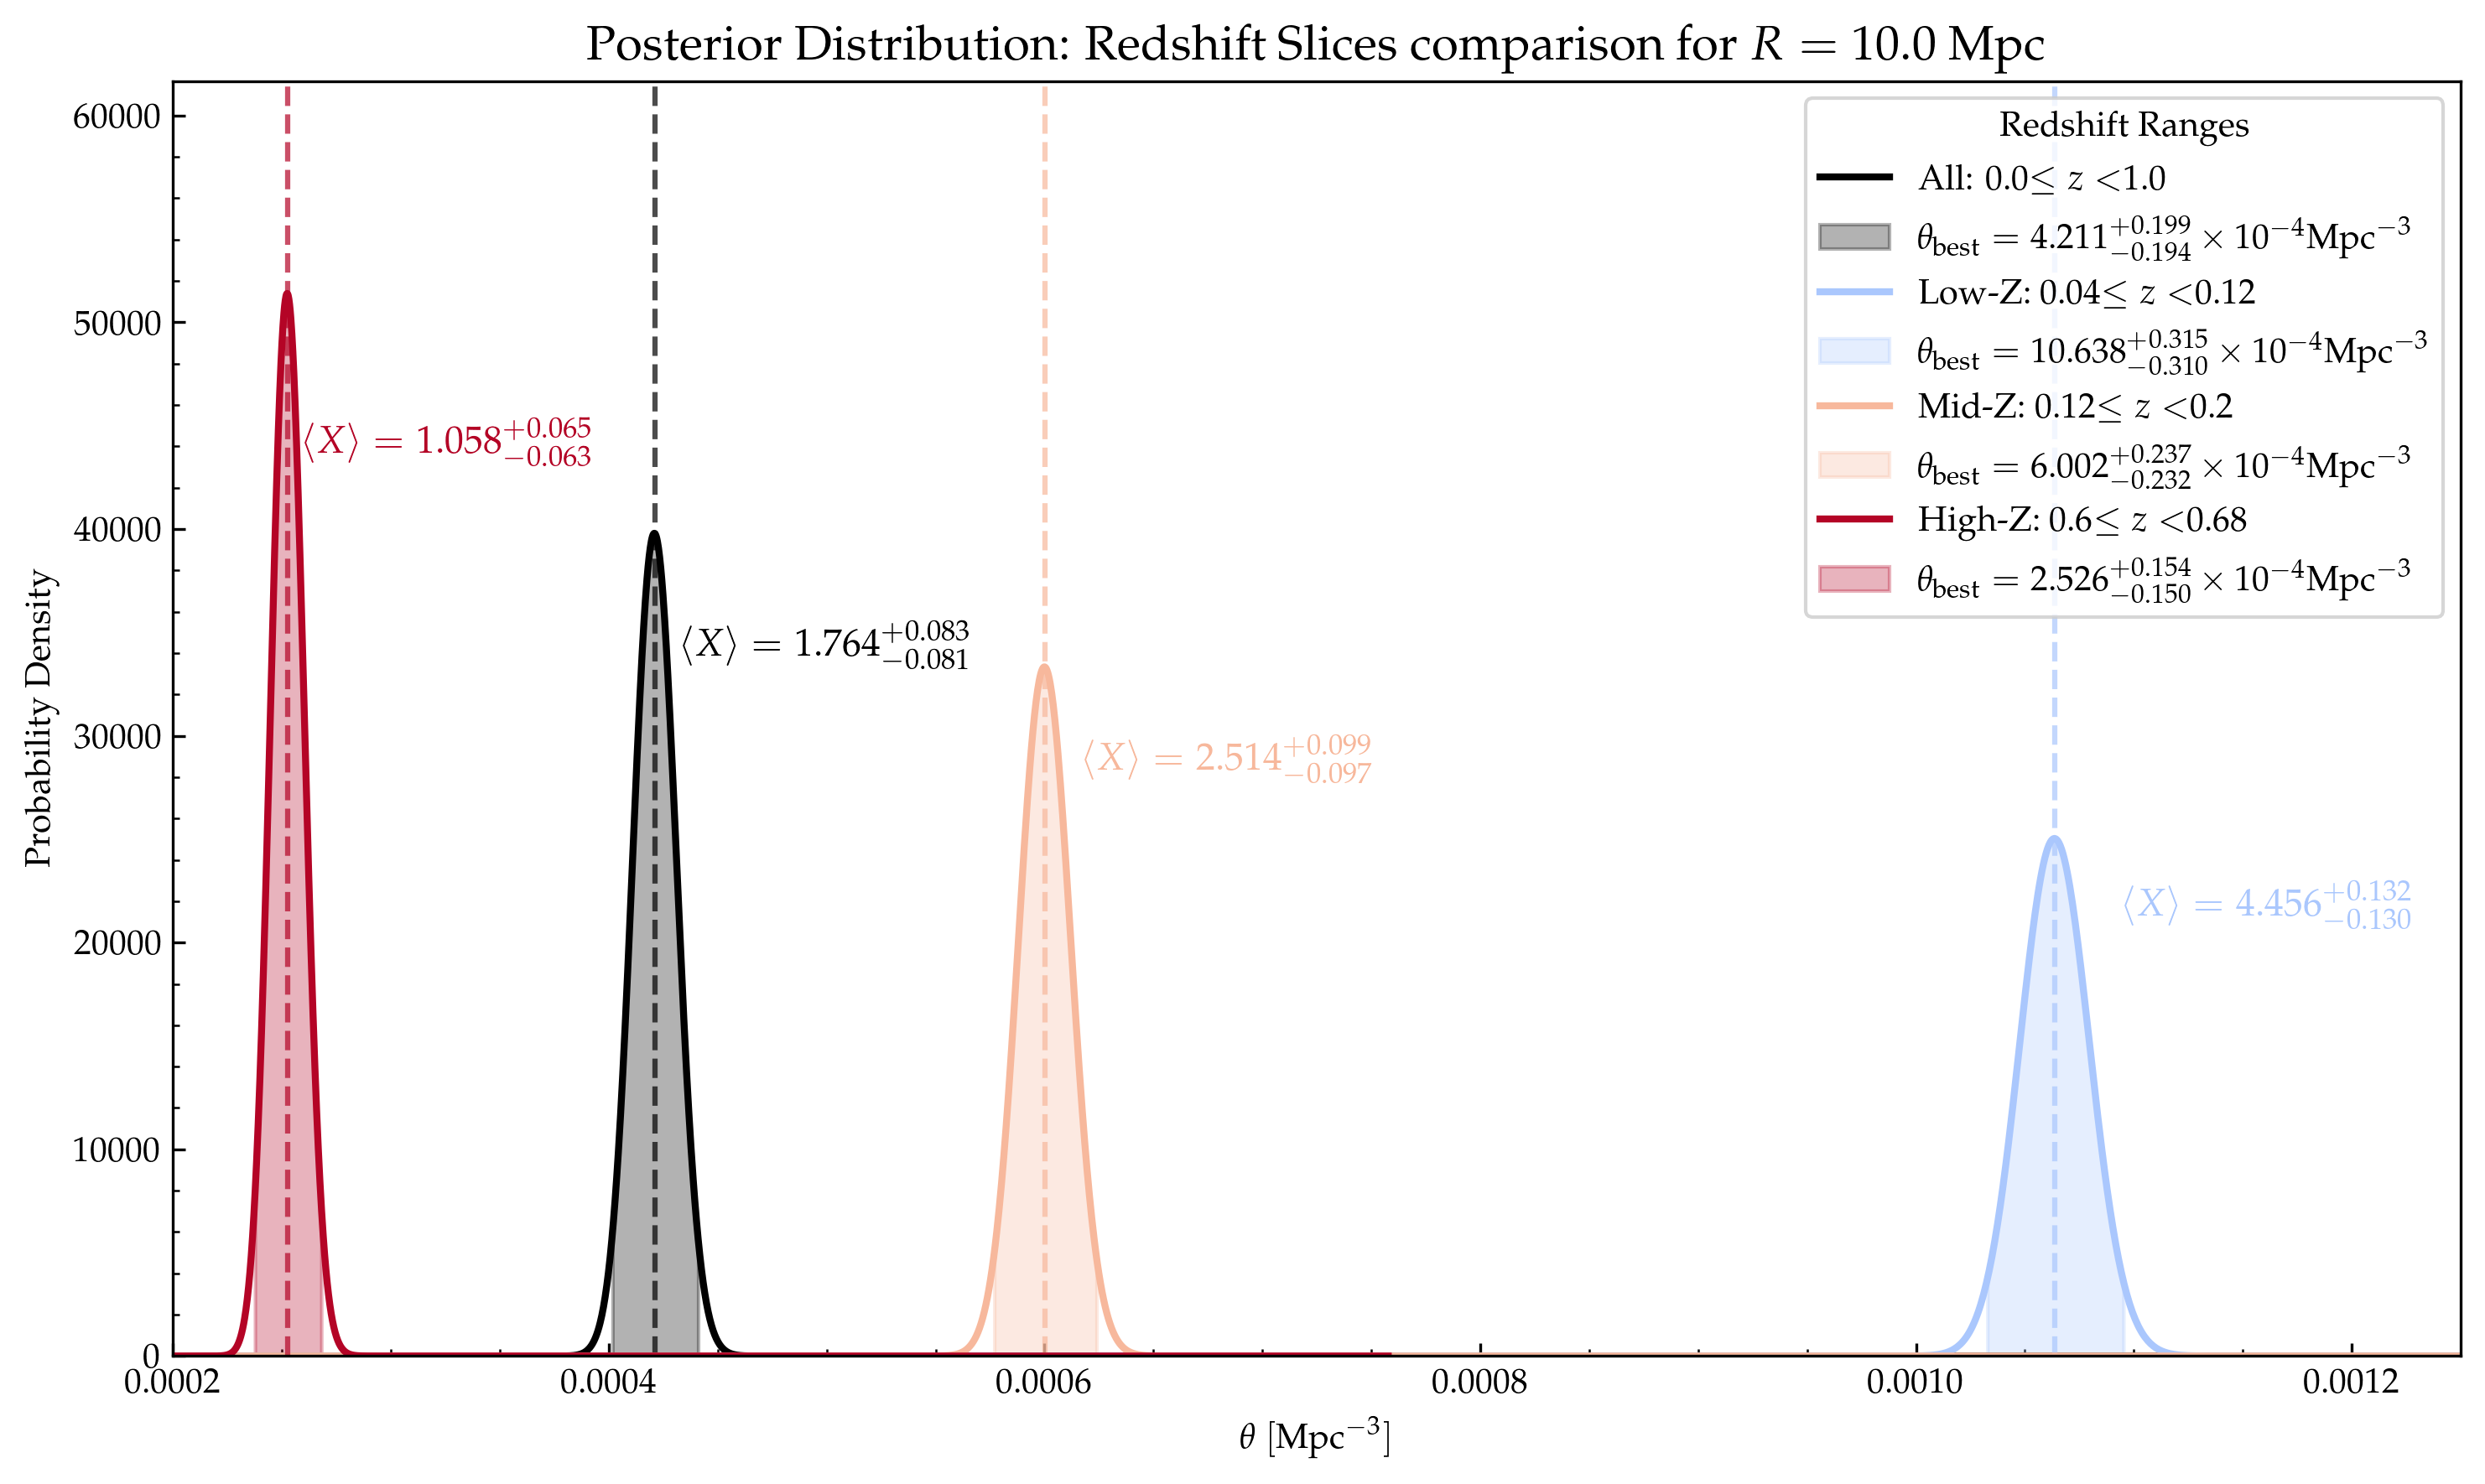

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define labels for the datasets
labels = ["All", "Low-Z", "Mid-Z", "High-Z"]

# Define priors
alpha_prior = 1e-6  # Non-informative prior
beta_prior = 1e-6

# Set up the colormap for the other labels (from dark blue to red, excluding "All")
colors = cm.get_cmap('coolwarm', len(labels))

# Create a figure for the combined plot
plt.figure(figsize=(10, 6), dpi=300)

for i, label in enumerate(labels):
    data_subset = dataset[dataset['Redshift Range'] == label]
    
    theta_mean, credible_interval, alpha_posterior, beta_posterior = posterior_mean_ci_poisson(data_subset, alpha_prior, beta_prior)

    theta_values = np.linspace(0, theta_mean * 3, 5000)
    
    posterior_pdf = posterior_distro_poisson(theta_values, alpha_posterior, beta_posterior)

    posterior_maximum = theta_values[posterior_pdf.argmax()]
    mean, cfi_lower, cfi_upper = theta_mean, credible_interval[0], credible_interval[1]
    theta_fill = np.linspace(cfi_lower, cfi_upper, 1000)

    # Use black for 'All' and colormap for other datasets
    if label == "All":
        plot_color = 'black'
    else:
        plot_color = colors(i)  # Shift index since 'All' has a fixed color

    # Plot the posterior distribution for each dataset with distinct color
    plt.plot(theta_values, posterior_pdf, color=plot_color, label=f'{label}: ' +f'{z_min_list[i]}' + r'$ \leq z < $'+f'{z_max_list[i]}', lw=2)

    # Plot the 95% credible interval as a shaded region for each dataset
    plt.fill_between(theta_fill, posterior_distro_poisson(theta_fill, alpha_posterior, beta_posterior), 
                     alpha=0.3, color=plot_color, label = r'$\theta_{\mathrm{best}}=' + f'{1e4*mean:.3f}' + r'^{+' + f'{1e4*(cfi_upper - mean):.3f}' + r'}_{-' + f'{1e4*(mean - cfi_lower):.3f}' + r'} \times 10^{-4} \mathrm{Mpc}^{-3}$')

    # Annotate with the posterior mean and credible interval in the title format
    plt.axvline(mean, linestyle='dashed', color=plot_color, alpha=0.7)
    # plt.text(mean * 1.05, posterior_pdf.max() * 0.8, 
    #          r'$\theta_{\mathrm{best}}=' + f'{1e4*mean:.3f}' + r'^{+' + f'{1e4*(cfi_upper - mean):.3f}' + r'}_{-' + f'{1e4*(mean - cfi_lower):.3f}' + r'} \times 10^{-4} \mathrm{Mpc}^{-3}$',
    #          color=plot_color, fontsize=10)

    plt.text(mean * 1.03, posterior_pdf.max() * 0.85, 
             r'$\langle X \rangle =' + f'{volume*mean:.3f}' + r'^{+' + f'{volume*(cfi_upper - mean):.3f}' + r'}_{-' + f'{volume*(mean - cfi_lower):.3f}' + r'}$',
             color=plot_color, fontsize=11)
# Set plot labels, title, and limits for the combined plot
plt.xlabel(r'$\theta$ $[\mathrm{Mpc}^{-3}]$')
plt.ylabel(r'Probability Density')
plt.title(r'Posterior Distribution: Redshift Slices comparison for $R =$ ' + f'{radius:.1f}' + ' Mpc', fontsize = 14)

# Set limits for x-axis and y-axis
plt.xlim(0.0002, 0.00125)
plt.ylim(0, posterior_pdf.max() * 1.2)

# Customize ticks
plt.tick_params(axis='both', which='major', direction='in')
plt.minorticks_on()
plt.tick_params(axis='both', which='minor', direction='in')

# Add a legend
plt.legend(title='Redshift Ranges', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


Total galaxies counted: 17238
Total survey volume: 41887902.05 Mpc³
Posterior mean of theta: 0.000412 galaxies per Mpc³
95% credible interval for theta: (0.000405, 0.000418) galaxies per Mpc³
Radius of each ball: 10.000000
Volume of each ball: 4188.790205
Expected number of galaxies per ball: 1.723900


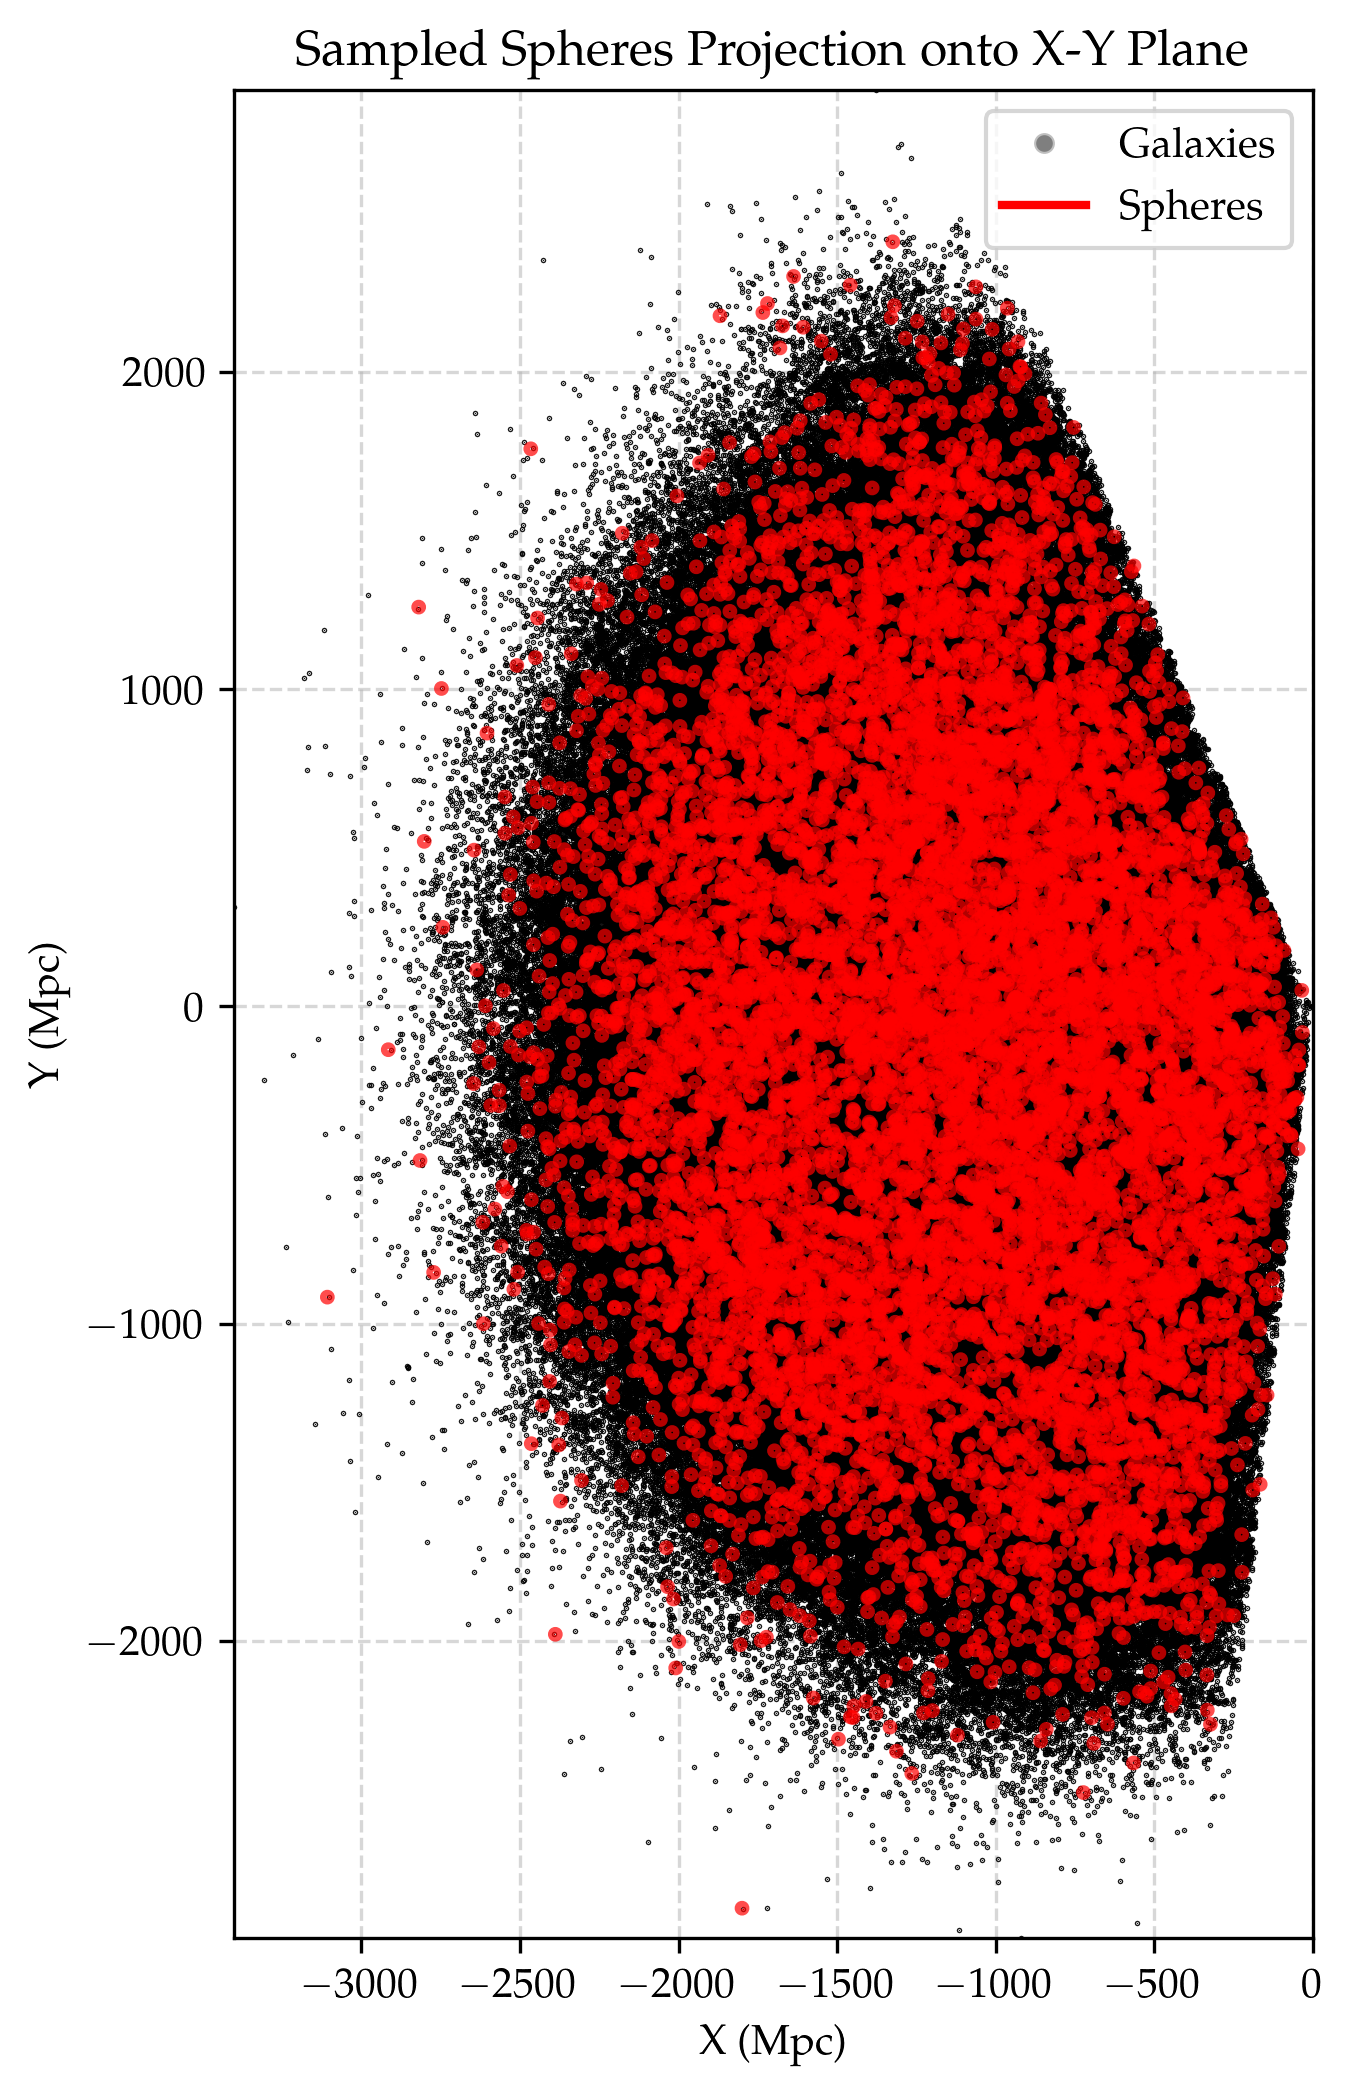

In [141]:
# Sphere parameters
num_spheres = 10000  # Adjust as needed
radius = 10 #25  # Sphere radius in Mpc
volume = (4/3) * np.pi * radius**3  # Sphere volume

# Randomly select sphere centers from galaxy positions
np.random.seed(0)
indices = np.random.choice(len(x), size=num_spheres, replace=False)
sphere_centers = np.column_stack((x[indices], y[indices], z[indices]))

# Add small random offsets to the sphere centers
max_offset = radius * 1.0 #radius * 0.5  # Ensure spheres stay within survey area
offsets = np.random.uniform(-max_offset, max_offset, size=(num_spheres, 3))
sphere_centers += offsets

# Ensure spheres are within survey bounds
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
z_min, z_max = z.min(), z.max()

sphere_centers[:, 0] = np.clip(sphere_centers[:, 0], x_min + radius, x_max - radius)
sphere_centers[:, 1] = np.clip(sphere_centers[:, 1], y_min + radius, y_max - radius)
sphere_centers[:, 2] = np.clip(sphere_centers[:, 2], z_min + radius, z_max - radius)

# Count galaxies within spheres
def count_galaxies_in_spheres(x, y, z, centers, radius):
    counts = []
    radius_squared = radius ** 2
    for center in centers:
        dx = x - center[0]
        dy = y - center[1]
        dz = z - center[2]
        distances_squared = dx**2 + dy**2 + dz**2
        count = np.sum(distances_squared <= radius_squared)
        counts.append(count)
    return np.array(counts)

counts = count_galaxies_in_spheres(x, y, z, sphere_centers, radius)

# Bayesian inference
alpha_prior = 1e-0  # Non-informative prior
beta_prior = 1e-0

total_counts = counts.sum()
total_volume = volume * num_spheres

alpha_posterior = alpha_prior + total_counts
beta_posterior = beta_prior + total_volume

theta_mean = alpha_posterior / beta_posterior
theta_variance = alpha_posterior / beta_posterior**2

credible_interval = gamma.interval(0.95, a=alpha_posterior, scale=1/beta_posterior)

print(f"Total galaxies counted: {total_counts}")
print(f"Total survey volume: {total_volume:.2f} Mpc³")
print(f"Posterior mean of theta: {theta_mean:.6f} galaxies per Mpc³")
print(f"95% credible interval for theta: ({credible_interval[0]:.6f}, {credible_interval[1]:.6f}) galaxies per Mpc³")
print(f"Radius of each ball: {(radius):.6f}" )
print(f"Volume of each ball: {(volume):.6f}" )
print(f"Expected number of galaxies per ball: {(theta_mean*volume):.6f}" )
